In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import wandb
from wandb.keras import WandbCallback
import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp

c:\Users\fredl\anaconda3\envs\tensorflowgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Wandb Login, Initialization and Configuration

In [2]:
!wandb login

wandb: Currently logged in as: fredlicombeau. Use `wandb login --relogin` to force relogin


In [3]:
# wandb.tensorboard.patch(root_logdir="./logs")
wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau", sync_tensorboard=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fredlicombeau. Use `wandb login --relogin` to force relogin


In [4]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32
}
CONFIGURATION = wandb.config

### Data Loading

In [5]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [7]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

### Dataset Infos

In [ ]:
for data in dataset[0].take(4):
    print(data)

In [ ]:
dataset_info

# Data Visualization

Exception ignored in: <function ZipFile.__del__ at 0x0000021403D9D5A0>
Traceback (most recent call last):
  File "c:\Users\fredl\anaconda3\envs\tensorflowgpu\lib\zipfile.py", line 1821, in __del__
    self.close()
  File "c:\Users\fredl\anaconda3\envs\tensorflowgpu\lib\zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


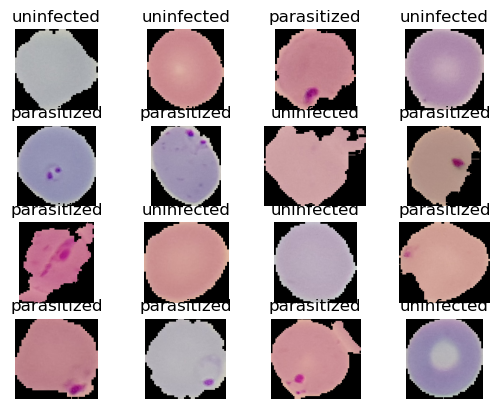

In [54]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

## Data Preprocessing

### Data Augmentation

In [55]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [56]:
original_image, label = next(iter(train_dataset))

In [57]:
augmented_image = tf.image.central_crop(original_image, 0.8)

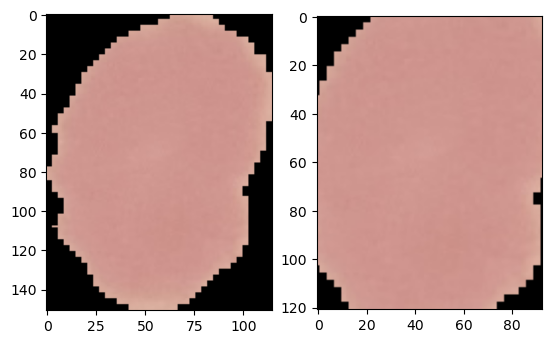

In [58]:
visualize(original_image, augmented_image)

In [8]:
IM_SIZE = 224
@tf.function
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [9]:
# tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255),
])

In [10]:
# tf.image augment
@tf.function
def augment(image, label):
    image, label = resize_rescale(image, label)

    image = tf.image.rot90(image) #, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
    image = tf.image.flip_left_right(image) # tf.image.stateless_random_flip_left_right(image)

    return image, label

In [11]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()

    @tf.function
    def call(self, image):
        return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [12]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal')
    # RandomRotation(factor=(0.25, 0.2501))
    # RandomFlip(mode='horizontal')
    # RandomContrast(factor=0.1)
])

@tf.function
def augment_layer(image, label):
    return augment_layers(resize_rescale_layers(image), training=True), label

In [13]:
# test_dataset = test_dataset.map(resize_rescale_layers)

In [14]:
# for image, label in train_dataset.take(1):
#     print(image, label)

### Mixup Data Augmentation

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    image = lamda * image_1 + (1-lamda) * image_2
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1-lamda) * tf.cast(label_2, dtype=tf.float32)
    
    return image, label

La stratégie de mixup n'est pas concluante dans ce cas

### CutMix Data Augmentation

In [ ]:
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)
    
    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1
    
    return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    r_y, r_x, r_h, r_w = box(lamda)

    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

    image = image_1 - pad_1 + pad_2

    lamda = tf.cast(1 - (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype=tf.float32)
    label = lamda * tf.cast(label_1, dtype=tf.float32) + (1-lamda) * tf.cast(label_2, dtype=tf.float32)

    return image, label

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

La stratégie CutMix n'est pas adaptée pour ce modèle

### Data Loading

In [15]:
BATCH_SIZE = 32
# train_dataset = (train_dataset
#                  .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
#                  .map(augment_layer) # .map(augment)
#                  .batch(BATCH_SIZE)
#                  .prefetch(tf.data.AUTOTUNE))
# train_dataset = (mixed_dataset
#                  .shuffle(buffer_size=8, reshuffle_each_iteration=True)
#                 #  .map(mixup)
#                  .map(cutmix)
#                  .batch(1)
#                  .prefetch(tf.data.AUTOTUNE))

In [16]:
# val_dataset = (val_dataset
#                .shuffle(buffer_size=32)
#                .map(resize_rescale)
#                .batch(BATCH_SIZE))

In [17]:
# print(train_dataset)
# print(val_dataset)

In [18]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

## WandB Dataset Versioning

### WandB Data Loading

In [32]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

print(dataset)

[<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [33]:
k = 0
for data in dataset[0]:
    with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
        np.savez(file, data)
    k += 1
    if(k%1000 == 0):
        print(k)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [34]:
def load_original_data():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:
        original_data = wandb.Artifact(
            name = "new_dataset", 
            type="raw_data",
            description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
            metadata = {"source": "TFDS",
                        "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                        "source_code": "tfds.image_classification.Malaria",
                        "version": "1.0.0",
                        "download_size": "337.08 MiB",
                        }
        )
        
        original_data.add_dir('dataset/')

        run.log_artifact(original_data)

In [35]:
load_original_data()

wandb: Adding directory to artifact (.\dataset)... Done. 0.0s


### WandB Data Preprocessing

In [36]:
with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:    
    artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [37]:
def resize_rescale(image):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [42]:
def preprocess_data():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:

        artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()

        preprocessed_data = wandb.Artifact(
            name = "preprocessed_dataset", 
            type="preprocessed_data",
            description = "A Preprocessed version of the Malaria dataset",
        )

        artifact_directory = "artifacts/new_dataset-v0/"

        dataset_x = []
        dataset_y = []
        
        for f in os.listdir(artifact_directory)[:1000]:
            with open(artifact_directory + f, 'rb') as file:
                npz_array = np.load(file, allow_pickle = True)
                
                x,y = npz_array.f.arr_0

                dataset_x.append(resize_rescale(x))
                dataset_y.append(y)
            
        # dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

        with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
            np.savez(file, [dataset_x, dataset_y])
        run.log_artifact(preprocessed_data)

In [43]:
preprocess_data()

wandb:   1 of 1 files downloaded.  


UnpicklingError: Failed to interpret file <_io.BufferedReader name='artifacts/new_dataset-v0/malaria_dataset_0.npz'> as a pickle

### WandB Data Splitting

In [ ]:
run = wandb.init()
artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/preprocessed_dataset:v2', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:

        artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/preprocessed_dataset:v2', type='preprocessed_data')
        artifact_dir = artifact.download()

        train_data = wandb.Artifact(
            name = "train_dataset", 
            type="preprocessed_data",
            description = "Training dataset",
        )
        val_data = wandb.Artifact(
            name = "val_dataset", 
            type="preprocessed_data",
            description = "Validation dataset",        
        )
        test_data = wandb.Artifact(
            name = "test_dataset", 
            type="preprocessed_data",
            description = "Test dataset",
                
            )
        
        artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

        with open(artifact_file, 'rb') as file:
            npz_arr = np.load(file, allow_pickle = True)
            arr = npz_arr.f.arr_0

        train_split = 0.8
        val_split = 0.1
        test_split = 0.1
        
        data_len = len(arr[0])

        train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
        val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
        test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]
        
        
        with train_data.new_file("train_dataset.npz", mode = "wb") as file:
            np.savez(file, train_arr)
            
        with val_data.new_file("val_dataset.npz", mode = "wb") as file:
            np.savez(file, val_arr)
            
        with test_data.new_file("test_dataset.npz", mode = "wb") as file:
            np.savez(file, test_arr)
            

        run.log_artifact(train_data)  
        run.log_artifact(val_data)      
        run.log_artifact(test_data)

In [ ]:
split_data()

### WandB Data Augmentation

In [ ]:
def augment(image):
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)

    return image

In [ ]:
def augment_data():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:
        artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/train_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        augmented_data = wandb.Artifact(
            name = "Augmented_dataset", 
            type="preprocessed_data",
            description = "An Augmented version of the Malaria train dataset",
        )

        artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"
        
        dataset_x = []

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle = True)
            
            arr = npz_array.f.arr_0

            for im in arr[0]:
                dataset_x.append(augment(im))
                dataset_y = arr[1]

        with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
            np.savez(file, [dataset_x, dataset_y])
        run.log_artifact(augmented_data)

In [ ]:
augment_data()

# Model Creation

### Sequential

In [ ]:
dropout_rate = 0.2
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    # InputLayer(input_shape=(None, None, 3)),

    # resize_rescale_layers,
    # augment_layers,

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(10, activation="relu", kernel_regularizer=L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation="sigmoid")
])

lenet_model.summary()

### Wandb Sequential

In [ ]:
CONFIGURATION = wandb.config

IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    # InputLayer(input_shape=(None, None, 3)),

    # resize_rescale_layers,
    # augment_layers,

    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=2*N_STRIDES),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=2*N_FILTERS+4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=2*N_STRIDES),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE),

    Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation="sigmoid")
])

lenet_model.summary()

### Fonctional

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2)
])

feature_extractor_seq_model.summary()

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input Image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu")(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation="relu")(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input Image')

# x = feature_extractor_model(func_input)
# Can be replaced by :
x = feature_extractor_seq_model(func_input)
x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name='Lenet_Model')
lenet_model_func.summary()

### Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()

        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input Image')

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name='Lenet_Model')
lenet_model_func.summary()

In [ ]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()

        self.feature_extractor = feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

        self.flatten = Flatten()

        self.dense_1 = Dense(100, activation="relu")
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(100, activation="relu")
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(1, activation="sigmoid")

    def call(self, x):
        x = self.feature_extractor(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

### Custom Layers

In [ ]:
class CustomDense(Layer):
    def __init__(self, output_units, activation):
        super(CustomDense, self).__init__()
        self.output_units = output_units
        self.activation = activation
    
    def build(self, input_features_shape):
        self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.output_units,), initializer="random_normal", trainable=True)
    
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b
        
        if self.activation == "relu":
            return tf.nn.relu(pre_output)
        elif self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    CustomDense(100, activation="relu"),
    BatchNormalization(),
    CustomDense(10, activation="relu"),
    BatchNormalization(),
    CustomDense(1, activation="sigmoid")
])

lenet_custom_model.summary()

### WandB Model Versioning

#### Untrained Model Versioning

In [ ]:
def log_model():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:
        untrained_model = wandb.Artifact(
            name = "Untrained_model", 
            type="model",
            description = "The initial version of our lenet model",
            metadata = CONFIGURATION
        )
        filename = 'lenet.h5'
        lenet_model.save(filename)

        untrained_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(untrained_model)

In [ ]:
log_model()

#### Trained Model versioning

In [ ]:
def train_and_log():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau") as run:
        artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/Augmented_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        trained_sequential_model = wandb.Artifact(
            name = "Trained_Sequential_model", 
            type="model",
            description = "A trained version of our model",
            metadata = CONFIGURATION,
        )

        artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"
            
        dataset_x = []

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle = True)
            
            arr = npz_array.f.arr_0

            for im in arr[0]:
                dataset_x.append(im)
                dataset_y = arr[1]
        

        d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
        d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

        d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

        train_d = (
            d
            .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
        )

        artifact = run.use_artifact('fredlicombeau/Detection-de-la-Malaria/Untrained_model:v0', type='model')
        artifact_dir = artifact.download()

        artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

        lenet_model = tf.keras.models.load_model(artifact_file)

        metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                    BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

        lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
            loss = BinaryCrossentropy(),
            metrics = metrics)

        lenet_model.fit(
            train_d,
            epochs = 3,
            verbose = 1,
            callbacks=[WandbCallback()],
        )
        
        filename = 'lenet_trained.h5'
        lenet_model.save(filename)

        trained_sequential_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(trained_sequential_model)

In [ ]:
train_and_log()

# Callbacks

In [ ]:
class LossCallback(Callback):
    def on_epoch(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
    def on_batch_end(self, batch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(batch+1, logs))

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
class LogImagesCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)

        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0])

        threshold = 0.5

        cm = confusion_matrix(labels, predicted > threshold)
        print(cm)

        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True)
        plt.title(f'Confusion matrix - {threshold}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')

        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')

        image = tf.image.decode_png(buffer.getvalue(), channels=3)
        image = tf.expand_dims(image, axis = 0)

        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)

        with image_writer.as_default():
            tf.summary.image('Training data', image, step=epoch)

In [ ]:
class LogImagesCallbackWandBPlot(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x, y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)

        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])

        print("labels", labels, labels.dtype)
        print("predicted", predicted, predicted.dtype)

        pred = []
        for i in range(len(predicted)):
            if predicted[i][0] < 0.5:
                pred.append([1, 0])
            else:
                pred.append([0, 1])
        pred = np.array(pred)
        
        # wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=pred, y_true=labels, class_names=["Parasitized", "Uninfected"])})
        # wandb.log({"ROC Curve": roc_curve(y_true=labels, y_probas=pred, labels=["Parasitized", "Uninfected"])})
        wandb.log({"Loss": logs['loss']})

In [ ]:
class LogImagesCallbackWandB(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []

        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
            
        labels = np.array([i[0] for i in labels])
        predicted = lenet_model.predict(np.array(inp)[:,0,...])

        threshold = 0.5

        cm = confusion_matrix(labels, predicted > threshold)
        
        plt.figure(figsize=(8,8))

        sns.heatmap(cm, annot=True,)
        plt.title('Confusion matrix - {}'.format(threshold))
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.axis('off')

        buffer = io.BytesIO()
        plt.savefig(buffer, format = 'png')

        image_array = tf.image.decode_png(buffer.getvalue(), channels=3)

        images = wandb.Image(image_array, caption="Confusion Matrix for epoch: {}".format(epoch))
            
        wandb.log({"Confusion Matrix": images})

### CSVLogger

In [ ]:
csv_callback = CSVLogger('logs.csv', separator=',', append=True)

### EarlyStopping

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

### Tensorboard

In [ ]:
!rm -rf ./logs/

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics/'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = "./logs/" + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1, profile_batch='100,132')

### LearningRateScheduler

In [ ]:
def scheduler(epoch, lr):
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    
    with train_writer.as_default():
        tf.summary.scalar('Learning Rate', data=learning_rate, step=epoch)
    return learning_rate
    
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

### ModelCheckpointing

In [ ]:
checkpoint_callback = ModelCheckpoint('checkpoints/', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=3)

In [ ]:
checkpoint_callback = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

### ReduceLearningRateOnPlateau

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

# Model Training

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

## Custom Loss and Metrics

### Custom Loss Method (without parameters)

In [ ]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

### Custom Loss Method (with parameters)

In [ ]:
def custom_bce_f(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR
    return loss

### Custom Loss Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR

### Custom Metric Method (without parameters)

In [ ]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

### Custom Metric Method (with parameters)

In [ ]:
def custom_accuracy_f(FACTOR):
    def metric(y_true, y_pred):
        bce = BinaryCrossentropy()
        return binary_accuracy(y_true, y_pred) * FACTOR
    return metric

### Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='Custom_Accuracy', FACTOR=1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype=tf.float32))

    def result(self):
        return self.accuracy
    
    def reset_state(self):
        self.accuracy.assign(0.)

## Training

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
              loss=BinaryCrossentropy(), # loss=CustomBCE(FACTOR), # loss=custom_bce_f(FACTOR), # loss=custom_bce,
              metrics=metrics) # metrics=CustomAccuracy()) # metrics=custom_accuracy_f(FACTOR)) # metrics='accuracy'
# lenet_model # lenet_model_func # lenet_sub_classed

In [ ]:
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='GPU')

In [ ]:
# history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=1, callbacks=[WandbCallback()])
# lenet_model # lenet_model_func # lenet_sub_classed # lenet_custom_model
# LossCallback() # csv_callback # scheduler_callback # checkpoint_callback
# , callbacks=[tensorboard_callback, scheduler_callback]) # , callbacks=[plateau_callback]) # , callbacks=[LogImagesCallback()]

In [ ]:
history = lenet_model.fit(train_dataset,
                          validation_data=val_dataset, 
                          epochs=3, 
                          # epochs=CONFIGURATION['N_EPOCHS'], 
                          verbose=1, 
                          callbacks=[LogImagesCallbackWandB()])
                        #   callbacks=[WandbCallback(validation_data=val_dataset, label=LABELS, data_type='image')])

In [88]:
wandb.finish()

### Hyperparameter Tuning

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001, 0.01, 0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
def model_tune(hparams):
    lenet_model = tf.keras.Sequential([
        InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
        # InputLayer(input_shape=(None, None, 3)),

        # resize_rescale_layers,
        # augment_layers,

        Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Dropout(rate=hparams[HP_DROPOUT]),

        Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),

        Flatten(),

        Dense(hparams[HP_NUM_UNITS_1], activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        Dropout(rate=dropout_rate),

        Dense(hparams[HP_NUM_UNITS_2], activation="relu", kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),

        Dense(1, activation="sigmoid")
    ])

    lenet_model.compile(
        optimizer=Adam(lr=hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    lenet_model.fit(val_dataset, epochs=1)
    _, accuracy = lenet_model.evaluate(val_dataset)
    return accuracy

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    hparams = {
                        HP_NUM_UNITS_1: num_units_1,
                        HP_NUM_UNITS_2: num_units_2,
                        HP_DROPOUT: dropout_rate,
                        HP_REGULARIZATION_RATE: regularization_rate,
                        HP_LEARNING_RATE: learning_rate,
                    }
                    file_writer = tf.summary.create_file_writer('logs/' + str(run_number))

                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy', accuracy, step=0)

                    print(f"For the run {run_number}, hparams num_units_1:{hparams[HP_NUM_UNITS_1]}, num_units_2:{hparams[HP_NUM_UNITS_2]}, dropout:{hparams[HP_DROPOUT]}, regularization_rate:{hparams[HP_REGULARIZATION_RATE]}, learning_rate:{hparams[HP_LEARNING_RATE]}")
                    run_number += 1

### Hyperparameter Tuning with WandB

In [ ]:
sweep_config = {
    "name" : "Malaria-Prediction-Sweep",
    "method" : "random",
    "metric": {
        "name" : "accuracy",
        "goal" : "maximize",
    },
    "parameters" : {
        "IM_SIZE": {
            "value" : 224,
        },
        "N_EPOCHS": {
            "value" : 1,
        },
        "KERNEL_SIZE": {
            "value" : 3,
        },
        "N_STRIDES": {
            "value" : 1,
        },
        "POOL_SIZE": {
            "value" : 224,
        },
        "N_FILTERS" : {
            "value" : 6,
        },
        "N_DENSE_1" : {
        "values" : [16, 32, 64, 128]
        },
        "N_DENSE_2" : {
        "values" : [16, 32, 64, 128]
        },
        "DROPOUT_RATE":{
        "min": 0.1,
        "max": 0.4
        },
        "REGULARIZATION_RATE" :{
        "distribution": "uniform",
        "min": 0.001,
        "max": 0.1
        },
        "LEARNING_RATE" :{
        "distribution": "uniform",
        "min": 1e-4,
        "max": 1e-2
        }
    },
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
def model_tune(config):
    lenet_model = tf.keras.Sequential([
        InputLayer(input_shape = (224, 224, 3)),

        Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
            activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
        Dropout(rate = config['DROPOUT_RATE'] ),

        Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
            activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        MaxPool2D (pool_size = 1, strides= 2),

        Flatten(),
        
        Dense(config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),
        Dropout(rate = DROPOUT_RATE),
        
        Dense(config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
        BatchNormalization(),

        Dense(1, activation = "sigmoid")
    ])


    return lenet_model

In [ ]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 1,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def train():
    with wandb.init(project="Detection-de-la-Malaria", entity="fredlicombeau", config=CONFIGURATION) as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
            optimizer= Adam(learning_rate = config['LEARNING_RATE']),
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )
        model.fit(val_dataset, epochs=2, callbacks = [WandbCallback()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

### Custom Training Loop

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %H%M%S')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/validation'
custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
    with tf.GradientTape() as recorder:
        y_pred = lenet_model(x_batch, training=True)
        loss = custom_bce(y_batch, y_pred)
    
    # wandb.log({'loss': loss.numpy()})

    partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
    METRIC.update_state(y_batch, y_pred)

    return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training=False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    
    return loss_val

In [ ]:
def train(model, loss_function, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
    for epoch in range(EPOCHS):
        print(f"Training starts for epoch number {epoch+1}")
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(x_batch, y_batch)

        print("Training loss", loss)
        print("The accuracy is: ", METRIC.result())
        with custom_train_writer.as_default():
            tf.summary.scalar('Training Loss', data=loss, step=epoch)
        with custom_train_writer.as_default():
            tf.summary.scalar('Training Accuracy', data=METRIC.result(), step=epoch)
        METRIC.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            loss_val = val_block(x_batch_val, y_batch_val)
            
        print("Validation loss", loss_val)
        print("The Validation accuracy is: ", METRIC_VAL.result())
        with custom_val_writer.as_default():
            tf.summary.scalar('Validation Loss', data=loss_val, step=epoch)
        with custom_val_writer.as_default():
            tf.summary.scalar('Validation Accuracy', data=METRIC_VAL.result(), step=epoch)
        METRIC_VAL.reset_states()

In [ ]:
train(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

### Visualization

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=LOG_DIR

In [ ]:
image = cv2.imread('cell.jpg')
print(image.shape)
image = tf.expand_dims(image, axis=0)
print(image.shape)

lenet_model.predict(image)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

In [ ]:
lenet_model.evaluate(test_dataset)

## Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

labels = np.array([i[0] for i in labels])

In [ ]:
labels

In [ ]:
np.array(inp).shape

In [ ]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])
predicted

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True)
plt.title(f'Confusion matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.axis('off')

## ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)

plt.figure(figsize=(14, 14))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()
skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [ ]:
def parasite_or_not(x):
    if x < 0.5:
        return 'P'
    return 'U'

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + " : " + str(parasite_or_not(lenet_model.predict(image)[0][0])))

    plt.axis('off')

# Loading and Saving

In [ ]:
lenet_model.save("lenet")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_loaded_model.evaluate(test_dataset)

In [ ]:
lenet_model.save("lenet.hdf5")

In [ ]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

In [ ]:
lenet_model.save_weights("weights/lenet_weights")

In [ ]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")

## Saving and Loading from Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/ 

In [ ]:
# !cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/ 